<a href="https://colab.research.google.com/github/AIREheart/Computational-Neuroscience/blob/main/assignments/Neuron_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SYDE 552 Assignment 1: Neuron Models
### Due Monday, January 29, 11:59pm
### Value: 15% of total marks for the course

The purpose of this assigment is to give you experience working with neuron models of various complexitites. To do so, we'll be using the BRIAN2 neural simulator, a Python library for creating arbitrary spiking neuron models by defining the underlying equations. We'll provide a basic tutorial for BRIAN that should include everything needed to do this assigment, but for additional help and existing neuron implmenetations, see the links below.

Work in groups of 1-2 people. Your code should be original, but you can borrow ideas and equations from these sources when building your models (please note when you do). Your submission will be a filled-out copy of this notebook (cells for code and written answers provided).

Additional sources
 - Equations: Dayan and Abbott Ch.5-6, Gerstner et al Ch.1-2
 - BRIAN2 documentation: https://brian2.readthedocs.io/en/stable/index.html
 - Working examples: https://brian2.readthedocs.io/en/stable/resources/tutorials/index.html, https://brian2.readthedocs.io/en/stable/user/multicompartmental.html, https://neuronaldynamics-exercises.readthedocs.io/en/latest/

# Install and Import Libraries


Install BRIAN2 (https://brian2.readthedocs.io/en/stable/introduction/install.html). You'll also need jupyter, numpy, scipy, and matplotlib. I reccomend using ```pip``` to install everything: from a terminal, run

```pip install brian2```

```pip install jupyter numpy scipy matplotlib```


open this jupyter notebook with

```jupyter notebook syde552assigment1.ipynb```

In [1]:
!pip install brian2

import numpy as np
import scipy
from brian2 import *
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 20.1 MB/s eta 0:00:00


# Intro to BRIAN2 (integrate-and-fire models)
BRIAN uses a unit system to give the constants in neuron equations appropriate physical dimensions

In [2]:
v_demo = -65*mV  # voltage
print(v_demo)

-65. mV


BRIAN does unit combinations, but will tell you when units don't match up

In [3]:
r_demo = 10*ohm  # resistance
i_demo = v_demo/r_demo  # calculate current
print(i_demo)

-6.5 mA


In [4]:
v_demo + i_demo  # volts + amps = (invalid) - should produce a DimensionMismatchError

DimensionMismatchError: Cannot calculate -65. mV add -6.5 mA, the units do not match (units are V and A).

Equations are written as strings, adding a ```: unit``` at the end

In [5]:
tau = 10*ms
eqn = '''dv/dt = -v/tau : volt'''
#print(eqn)

Note that ```mV``` describes the unit for the new variable ```v``` that is being defined by the equation, not the quantity on the left-hand-side (which would here be mV/s).

If you want to have the variable be unitless, you can type ```: 1```.

In [6]:
eqn = '''
dv/dt = (1-v)/tau: 1  # leak towards v_eq=1
'''
#print(eqn)

Create a neuron by defining an "ensemble" (population) of neurons

In [7]:
ens = NeuronGroup(1, eqn, method='exact')  # n=1 neurons in the population, "exact" numerical integration

Set up a probe to record state variables from neurons in ```ens```

In [8]:
p = StateMonitor(ens, 'v', record=True)

Run the simulation

In [9]:
run(100*ms)


Plot the result

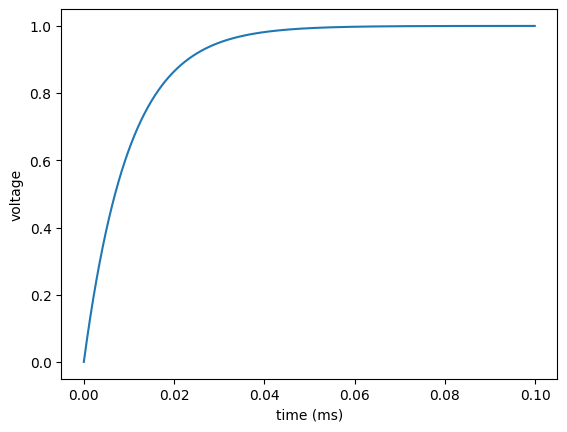

In [10]:
fig, ax = plt.subplots()
ax.plot(p.t, p.v[0])  # measuring from the first neuron in "ens" [index=0]
ax.set(xlabel='time (ms)', ylabel='voltage')
plt.show()

Now let's add in a spiking mechanism, which includes a "threshold" and a "reset" mechanism.

The ```threshold``` block defines the condition which must be met to register a "spike".

The ```reset``` block defines what happens when a spike occurs.

Before we start, let's explicitly create a scope for this particular model. This avoids accidentally carrying over from variables / constants defined earlier in the notebook.

In [11]:
start_scope()

tau = 10*ms
v_target = 10*mV
theta = 5*mV
v_reset = -20*mV

eqn = '''dv/dt = (v_target - v)/tau : volt'''

ens = NeuronGroup(1, eqn, threshold='v>theta', reset='v = v_reset', method='euler')

Notice that we started using real units, and changed our numerical integration scheme to a simple numerical solver (Euler's Method)

We also need to define a new type of probe to collect spikes

In [12]:
p = StateMonitor(ens, 'v', record=True)
p_s = SpikeMonitor(ens)

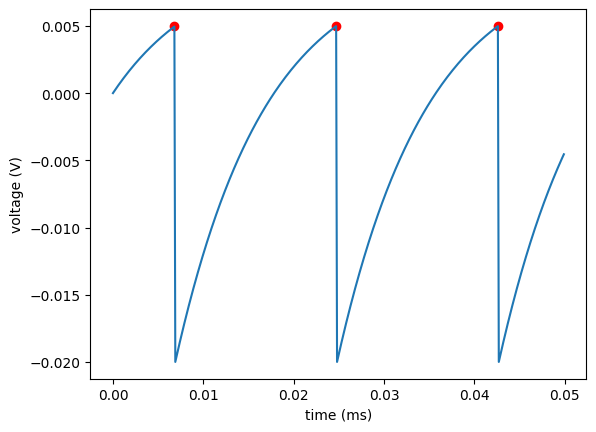

In [13]:
run(50*ms)

fig, ax = plt.subplots()
ax.plot(p.t, p.v[0])
ax.scatter(p_s.t, theta*np.ones((len(p_s.t))), color='r')
ax.set(xlabel='time (ms)', ylabel='voltage (V)')
plt.show()

Reset and refractory mechanisms can also be specified as complex expressions, each defined by its own string.

We'll add a unitless state variable ```a``` that is incremented when a spike occurs, and increases the spike threshold and the refractor period

WARNING    /tmp/ipython-input-398699949.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
 [py.warnings]
  plt.legend()



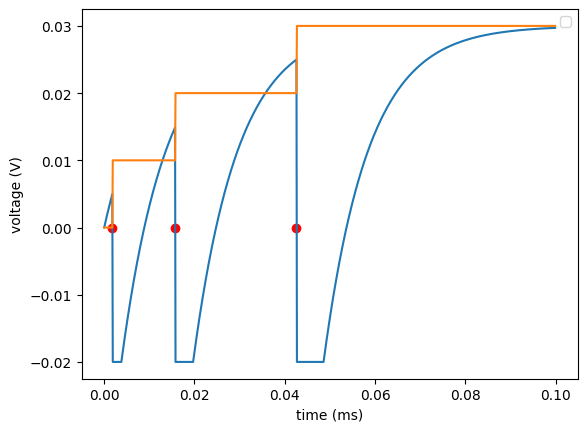

In [14]:
start_scope()

tau = 10*ms
v_target = 30*mV
theta = 5*mV
v_reset = -20*mV

eqn = '''
dv/dt = (v_target - v)/tau : volt  (unless refractory)
a : 1  # unitless
'''

thr = '''v > theta + a*volt'''  # convert a to volts to allow addition

rst = '''
v = v_reset
a += 0.01
'''

ref = '''a*200*ms'''

ens = NeuronGroup(1, eqn, threshold=thr, reset=rst, refractory=ref, method='euler')

p_v = StateMonitor(ens, 'v', record=True)
p_a = StateMonitor(ens, 'a', record=True)
p_s = SpikeMonitor(ens)

run(100*ms)

fig, ax = plt.subplots()
ax.plot(p_v.t, p_v.v[0])
ax.plot(p_a.t, p_a.a[0])
ax.scatter(p_s.t, np.zeros((p_s.t.shape)), color='r')
ax.set(xlabel='time (ms)', ylabel='voltage (V)')
plt.legend()
plt.show()


# Question 1: LIF Neuron

## 1.1 [2 points] Implement the LIF neuron. Simulate the neuron with a 2mA external current. Plot voltage vs time.

#### Equations:
$\frac{dV}{dt} = -\frac{1}{RC}(V - E_{leak}) + \frac{1}{C}I_{ext}$

if $V>V_{thr}$:
- set $V=V_{reset}$
- begin a refractory period of $\tau_{ref}$ ms

#### Constants:
 - $R = 10$ ohm
 - $C = 1$ mfarad
 - $\tau_{ref} = 2$ ms
 - $E_{leak} = -65$ mV
 - $V_{thr} = -50$ mV
 - $V_{reset} = -80$ mV
 - $I_{ext} = 2$ mA

#### Notes
 - set state variables using ```ens.v = v_initial```

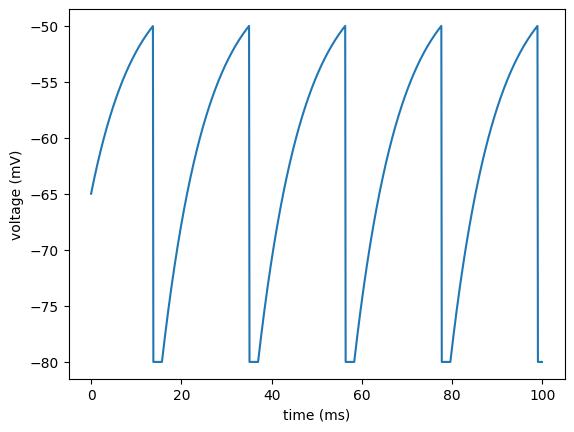

5


In [15]:

#import numpy as np
#import scipy
#from brian2 import *
#import matplotlib.pyplot as plt

# your solution here
start_scope()
# constant = ...
R = 10*ohm
C = 1*mfarad
tau_ref = 2*ms
E_leak = -65*mV
v_thr = -50*mV
v_reset = -80*mV
I_ext = 2*mA

eqn = '''
dv/dt = (-1/(R*C))*(v - E_leak) + (1/C)*I_ext : volt (unless refractory)

'''
thr = '''v > v_thr'''  # convert a to volts to allow addition

rst = '''
v = v_reset
'''

ref = '''tau_ref'''

# threshold = ''' ... '''
# reset = ''' ... '''
# refractory = ''' ... '''
# ens = NeuronGroup(...)
ens = NeuronGroup(1, eqn, threshold=thr, reset=rst, refractory=ref, method="euler")
ens.v = E_leak


probe = StateMonitor(ens, 'v', record=True)
spikes = SpikeMonitor(ens)

run(100*ms)
fig, ax = plt.subplots()
ax.plot(probe.t/ms, probe.v[0]/mV)  # measuring from the first neuron in "ens" [index=0]
ax.set(xlabel='time (ms)', ylabel='voltage (mV)')
plt.show()
#plt.title("")
print(spikes.num_spikes)

## 1.2 [2 points] Create response curves for the LIF neuron
 - (a) Inject a constant test current into the neuron, run the simulation, and count the number of spikes. Repeat this for a variety of test currents, then plot average firing rate (spikes/second) versus input current.
 - (b) Choose a new value of R or C, run the experiment from (a) again, and add the new response curve to your plot
 - (c) Choose a new value of tau_ref, run the experiment from (a) again, and overlay the new resopnse curve to your plot

#### Parameters
- Test currents: 1-20mA in increments of 0.5mA
- Simulation duration: $200$ms

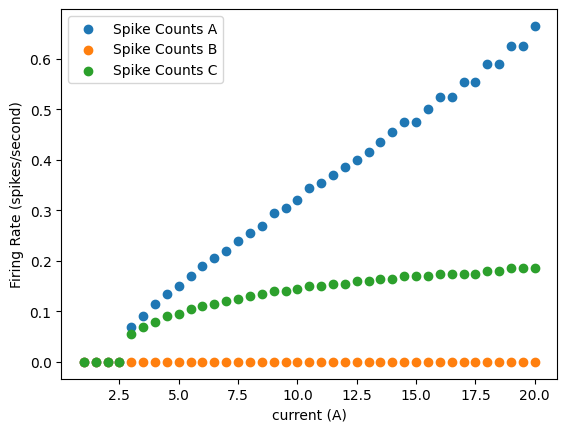

[np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.07), np.float64(0.09), np.float64(0.115), np.float64(0.135), np.float64(0.15), np.float64(0.17), np.float64(0.19), np.float64(0.205), np.float64(0.22), np.float64(0.24), np.float64(0.255), np.float64(0.27), np.float64(0.295), np.float64(0.305), np.float64(0.32), np.float64(0.345), np.float64(0.355), np.float64(0.37), np.float64(0.385), np.float64(0.4), np.float64(0.415), np.float64(0.435), np.float64(0.455), np.float64(0.475), np.float64(0.475), np.float64(0.5), np.float64(0.525), np.float64(0.525), np.float64(0.555), np.float64(0.555), np.float64(0.59), np.float64(0.59), np.float64(0.625), np.float64(0.625), np.float64(0.665)]
[np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float6

In [16]:
# your solution here
start_scope()

I=numpy.arange(1,20.5,0.5)*mA

R2 = 0.1*ohm
tau_ref1 = 0.02*ms
spike_counts_a = []
spike_counts_b = []
spike_counts_c = []
R1 = 6*ohm
C1 = 1*mfarad
tau_ref2 = 4*ms
E_leak = -65*mV
v_thr = -50*mV
v_reset = -80*mV
#I_ext = 2*mA


def LIF_response(I, R, C, tau):
    #start_scope()
    eqn = '''
    dv/dt = (-1/(R*C))*(v - E_leak) + (1/C)*I : volt (unless refractory)
    '''
    thr = 'v > v_thr'
    rst = 'v = v_reset'
    ref = 'tau'

    ens1 = NeuronGroup(1, eqn, threshold=thr, reset=rst, refractory=ref, method="euler" )
    ens1.v=E_leak
    spikes = SpikeMonitor(ens1, 'v')
    spike_time = StateMonitor(ens1, 'v', record=True)

    run(200*ms)
    spike_count=spikes.num_spikes/200
    return (spike_count)


for i in range(len(I)):     #a)
    spike_counts_a.append(LIF_response(I[i], R1, C1, tau_ref1))
for i in range(len(I)):   #b)
    spike_counts_b.append(LIF_response(I[i], R2, C1, tau_ref1))
for i in range(len(I)):
    spike_counts_c.append(LIF_response(I[i], R1, C1, tau_ref2))

# plot spike_counts_a, spike_counts_b, spike_counts_c (vs input curent)
fig, ax = plt.subplots()
ax.scatter(I/mA, spike_counts_a, label="Spike Counts A")

ax.scatter(I/mA, spike_counts_b, label="Spike Counts B")

ax.scatter(I/mA, spike_counts_c, label="Spike Counts C")

ax.set(xlabel='current (A)', ylabel='Firing Rate (spikes/second)')


plt.legend()

plt.show()
print(spike_counts_a);print(spike_counts_b);print(spike_counts_c)

In [19]:
F(I0) = 1/(T_ref - Trc* (1-V_thr/(R*10)))

SyntaxError: cannot assign to function call here. Maybe you meant '==' instead of '='? (ipython-input-4048904773.py, line 1)

## 1.3 [2 points] Add an adaptation term to the LIF neuron. Calculate the inter-spike-interval and plot it versus spike number to demonstrate adaptation.
 - Inter-spike-interval (ISI) is defined as the length of time between two spikes. To calculate it, compute the difference between the spike times returned from a BRIAN spike monitor
   - tip: use ```np.diff()```
 - Plot the resulting array of values as a scatter plot: $y$ values will be ISI in ms, and $x$ values will range from $1$ to $C$, the spike count value at the end of the simulation.

#### Additional Equations
$\frac{da}{dt} = -\frac{a}{\tau_a}$

$v_{thr} = -50mV + a$

if $v > v_{thr}$:
  - $a = a + \Delta A$
  
#### Additional Constants
- $I_{ext} = 2$mA
- $\tau_a = 100$ ms
- $\Delta A = 1$ mV
- runtime = 500 ms

<spikemonitor_2.t: array([  0. ,  70. , 179.6, 289.5, 399.3]) * msecond>


TypeError: _AxesBase.set_ylim() takes from 1 to 3 positional arguments but 4 were given

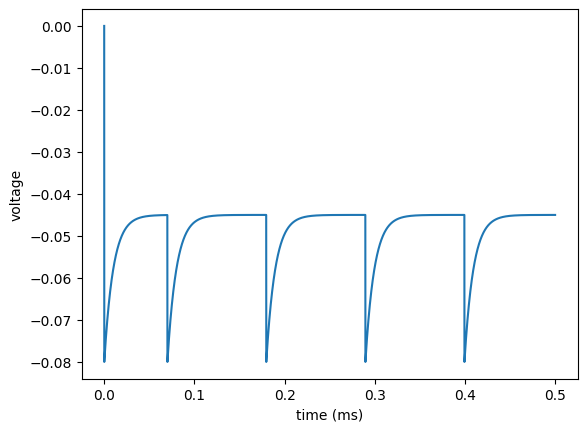

In [20]:
# your solution here
start_scope()
R = 10*ohm
C = 1*mfarad
tau_ref = 2*ms
E_leak = -65*mV
v_thr = -50*mV
v_reset = -80*mV
I_ext = 2*mA
tau_a = 100*ms
theta = 5*mV

spike_times = []

eqn = '''
    dv/dt = -(1/(R*C))*(v - E_leak) + (1/C)*I_ext : volt
    da/dt = -a/tau_a :1
    '''


thr = '''v > v_thr + a*volt'''  # convert a to volts to allow addition

rst = '''
v = v_reset
a += 0.01
'''

ref = '''a*200*ms'''



ens2 = NeuronGroup(1, eqn, threshold=thr, reset=rst, method="euler" )
#ens2.v = -65*volt

spikes = SpikeMonitor(ens2)
state = StateMonitor(ens2, 'v', record=True)
spike_times = spikes.t

run(500*ms)
print(spike_times)

#plotting
fig, ax = plt.subplots()
ax.plot(state.t, state.v[0])  # measuring from the first neuron in "ens" [index=0]
ax.set(xlabel='time (ms)', ylabel='voltage')
plt.ylim(-0.09, -0.04, 0.01)
plt.show()
num_spikes = np.arange(1, spikes.num_spikes, 1)
#x_lim(1,spike_time[-1]) last array value is the x-axis
#y vals are the np.diff(spike_times) should kind of look hyperbolic
print(spikes.num_spikes)
fig, ax = plt.subplots()
ax.plot(num_spikes, np.diff(spike_times))
ax.set(xlabel='number of spikes', ylabel='ISI (s)')
plt.show()
print(num_spikes) #wrong x axis?
#plot the adaptation curve


## [Bonus] 1.4 [1 point] Read about other extensions to the LIF model, such as quadratic- or exponential-integrate-and fire. Implement that neuron model, then
 - (a) plot the voltage trace
 - (b) plot the response curve
 - (c) plot spike adaptation

In [ ]:
# your solution here (optional)

# Question 2: Wilson Neuron
In his 1999 paper "Simplified dynamics of human and mammalian neocortical neurons", Wilson reduced the Hodgkin-Huxley model down to three coupled differential equations. He showed that this neuron model reproduced action potential dynamics and other electrophysiological measures without any artificial reset mechanisms.

- $\tau_v \frac{dv}{dt} = -(17.81 + 47.58v + 33.80v^2)(v - 0.48) - 26r(v + 0.95) - 13h(v + 0.95) + I_{ext}$
- $\tau_r \frac{dr}{dt} = -r + 1.29v + 0.79 + 3.30(V + 0.38)^2$
- $\tau_h \frac{dh}{dt} = -h + 11(v + 0.754)*(v + 0.69)$

where $v$ is voltage, $r$ is a recovery variable, and $h$ is a conductance variable.

- $\tau_v = 0.97$ms
- $\tau_r = 5.6$ms
- $\tau_H = 99.0$ms
- $dt = 0.05$ms

## 2.1 [2 points] Implement the Wilson Neuron.  Produce an action potential by injecting an external current (I=3 for 0.1ms). Plot voltage vs time. How does the shape of the action potential compare to observed electrophysiology?

#### Tips:
 - Units are weirdly defined in this model: ```v``` varies between $-0.9$ and $0.3$, and time constants are given in seconds. It's easiest to just make the state variables unitless (e.g.```dv/dt = ... : 1```)
 - set the simulation timestep using ```defaultclock.dt = 0.025*ms```
 - set initial conditions to keep the neuron from firing a transient spike at simulation startup:
  - $v_0=-0.75$
  - $r_0=0.2$
 - use ```v**2``` to write powers in an ```eqn=''' ... '''``` block, not ```v^2```
 - run the simulation long enough to observe the full recovery period

<StateMonitor, recording ['v'] from 'neurongroup_4'>


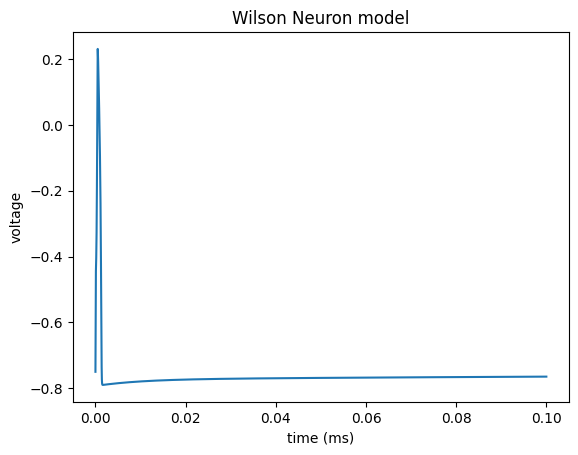

In [21]:
# your solution here
start_scope()
tau_v = 0.97*ms
tau_r = 5.6*ms
tau_h = 99*ms
dt = 0.05*ms
v0 = -0.75
r0 = 0.2
#v_thr = -50
#I_ext = 3*mA
#print(I_ext)

eqn = '''
dv/dt = (-1*(17.81 + 47.58*v + 33.80*v**2)*(v - 0.48) - 26*r*(v + 0.95) - 13*h*(v + 0.95) + I_ext(t))/tau_v :1
dr/dt = (-r + 1.29*v + 0.79 + 3.30*(v + 0.38)**2)/tau_r :1
dh/dt = (-h + 11*(v +0.754)*(v + 0.69))/tau_h :1
'''

I_ext = TimedArray([3,0], dt = 0.1*ms)

ens3 = NeuronGroup(1, eqn, method = 'euler')
ens3.v = v0
ens3.r = r0
#ens3.i[0] = I_ext*mV
wilson_probe_v = StateMonitor(ens3, 'v', record=True)
defaultclock.dt = 0.025*ms
run(100*ms)

print(wilson_probe_v)
fig, ax = plt.subplots()
ax.plot(wilson_probe_v.t, wilson_probe_v.v[0])
ax.set(xlabel='time (ms)', ylabel='voltage')
plt.title('Wilson Neuron model')
plt.show()



[link text](https://)##### Your description of the action potential here
An action potential generated by the Wilson neuron model shows a sharp spike that plateaus close to the initial voltage, v0.
Rather than shoot right back down in its repolarization state after the rapid depolarization, there looks to be some temporal influence. This is evident by studying the plots after changing v's time constant, whereby an increase in tau_v to 6 ms dramatically decreases the sloping of the depolarization (relaying a longer time for the voltage to relax).

### 2.2 [1 point] Coupled ODEs in complex neuron models are numerically sensitive, and the system can explode under certain conditions. Show that increasing the timestep or injecting a powerful, sustained current produces unrealistic voltage traces.

<StateMonitor, recording ['v'] from 'neurongroup_5'>


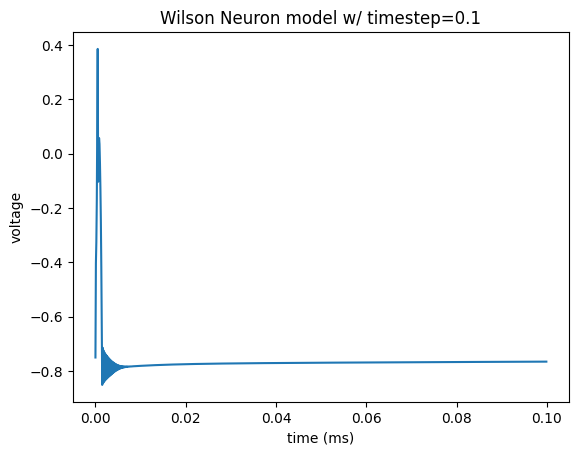

In [22]:
# your solution here
#plot simulations where defaultclock.dt = 0.025*ms changes up to 1
start_scope()
tau_v = 0.97*ms
tau_r = 5.6*ms
tau_h = 99*ms
dt = 0.05*ms
v0 = -0.75
r0 = 0.2
#v_thr = -50
#I_ext = 3*mA
#print(I_ext)

eqn = '''
dv/dt = (-1*(17.81 + 47.58*v + 33.80*v**2)*(v - 0.48) - 26*r*(v + 0.95) - 13*h*(v + 0.95) + I_ext(t))/tau_v :1
dr/dt = (-r + 1.29*v + 0.79 + 3.30*(v + 0.38)**2)/tau_r :1
dh/dt = (-h + 11*(v +0.754)*(v + 0.69))/tau_h :1
'''

I_ext = TimedArray([3,0], dt = 0.1*ms)

ens3 = NeuronGroup(1, eqn, method = 'euler')
ens3.v = v0
ens3.r = r0
#ens3.i[0] = I_ext*mV
wilson_probe_v = StateMonitor(ens3, 'v', record=True)
defaultclock.dt = 0.1*ms
run(100*ms)

print(wilson_probe_v)
fig, ax = plt.subplots()
ax.plot(wilson_probe_v.t, wilson_probe_v.v[0])
ax.set(xlabel='time (ms)', ylabel='voltage')
plt.title('Wilson Neuron model w/ timestep=0.1')
plt.show()


## 2.3 [1 point] Show the Wilson neuron exhibits spike adaptation by plotting ISI versus spike number. How does this adaptation compare to the adaptive LIF neuron from Question 1.3?

#### Note
- you will need to think of a good way to define a "spike" for continuous voltages

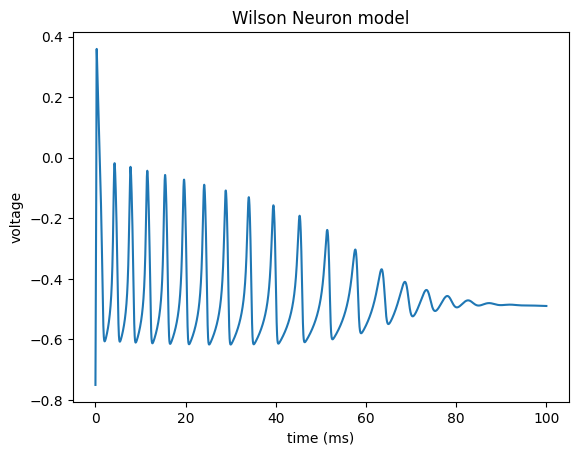

[  11  169  311  460  618  786  965 1156 1360 1578 1811 2056 2304 2538
 2744 2935 3121 3305 3491 3675]
[ 0.275  4.225  7.775 11.5   15.45  19.65  24.125 28.9   34.    39.45
 45.275 51.4   57.6   63.45  68.6   73.375 78.025 82.625 87.275 91.875] ms


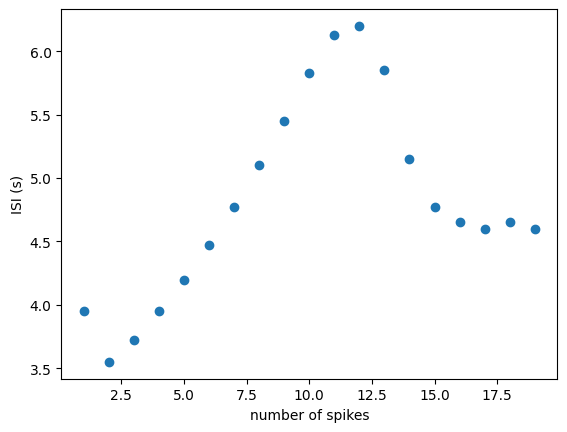

In [23]:
# your solution here

start_scope()
tau_v = 0.97*ms
tau_r = 5.6*ms
tau_h = 99*ms
dt = 0.05*ms
v0 = -0.75
r0 = 0.2
#v_thr = -50
#I_ext = 3*mA
#print(I_ext)

eqn = '''
dv/dt = (-1*(17.81 + 47.58*v + 33.80*v**2)*(v - 0.48) - 26*r*(v + 0.95) - 13*h*(v + 0.95) + I_ext(t))/tau_v :1
dr/dt = (-r + 1.29*v + 0.79 + 3.30*(v + 0.38)**2)/tau_r :1
dh/dt = (-h + 11*(v +0.754)*(v + 0.69))/tau_h :1
'''

I_ext = TimedArray([3,0], dt = 100*ms)

ens4 = NeuronGroup(1, eqn, method = 'euler')
ens4.v = v0
ens4.r = r0

state = StateMonitor(ens4, 'v', record=True)

defaultclock.dt = 0.025*ms
run(100*ms)

fig, ax = plt.subplots()
ax.plot(state.t/ms, state.v[0])
ax.set(xlabel='time (ms)', ylabel='voltage')
plt.title('Wilson Neuron model')
plt.show()



volt_probe = []
volt_probe = state.v[0,:]

#print(volt_probe)
peaks = scipy.signal.find_peaks(volt_probe)
volts = peaks[0]
print(peaks[0])
#volt_time = np.concatenate(state.v[0,:], state.t[0,:])

print(state.t[volts])
num_spikes=(np.arange(1, len(volts), 1))


fig, ax = plt.subplots()
ax.scatter(num_spikes, np.diff(state.t[volts]/ms))
ax.set(xlabel='number of spikes', ylabel='ISI (s)')
plt.show()
#print(volt_probe.shape)


#peak_inds, _ = find_peaks(signal)
#peak_ts = ts[peak_inds]
#intervals = np.diff(peak_ts)

# Intro to BRIAN2 (compartmental models)

BRIAN2 also support multicompartment models (https://brian2.readthedocs.io/en/stable/user/multicompartmental.html).  In addition to defining the equations governing the membrane dynamics (i.e. ion channels), building a compartmental neuron requires specifying a morphology. To do this, we'll use BRIAN2's pre-built sections

In [24]:
soma = Soma(diameter=30*um)  # defines a sphere

Attach new sections to a previously defined section like so

In [25]:
soma.axon = Cylinder(length=100*um, diameter=1*um, n=10)  # n=10 compartments in this section
soma.dendrite = Cylinder(length=50*um, diameter=2*um, n=5)
soma.dendrite.branch1 = Cylinder(length=10*um, diameter=1*um, n=3)
soma.dendrite.branch2 = Cylinder(length=10*um, diameter=1*um, n=3)

Now we can define a SpatialNeuron according to our biophysical equations. BRIAN will automatically solve the cable equation between all the compartments, so specifying $\frac{dv}{dt}$ and $\frac{d^2v}{dx^2}$ is unnecessary: the user only needs to define the transmembrane and external currents. Notice that physical constants and state variables are now defined relative to space.

In [26]:
gL = 1e-4*siemens/cm**2  # leak conductance
Cm = 1*uF/cm**2  # membrane capacitance
Ri = 100*ohm*cm  # longitudinal (intracellular) resistivity
EL = -70*mV  # leak reversal potential

eqn = '''
Im = gL * (EL - v) : amp/meter**2  # total ionic (membrance) current
I : amp (point current)  # external current
# dv/dt, d2v/dx2, and I_long are calculated automatically
'''

neuron = SpatialNeuron(morphology=soma, model=eqn, Cm=Cm, Ri=Ri)

Set the membrane voltage of all compartments to -65mV, then apply an external current a few specific compartments. Note the use of ```.main``` to target a specific compartment

In [27]:
neuron.v = EL + 10*mV  # applies to state variables in soma compartment AND all connected compartments
neuron.main.v = EL + 10*mV  # applies to state variables in soma compartment
neuron.main.I[0] = 1*nA  # applies only to soma
neuron.dendrite.I[3] = 0.5*nA  # applies to a compartment part way down the dendrite
neuron.dendrite.branch1.I[1] = 0.5*nA

To detect spikes, we'll add a threshold condition. To ensure that multiple spikes don't get registered if this condition remains true for a while (e.g. v>v_thr), we'll also specify a refractory condition.

In [28]:
neuron = SpatialNeuron(morphology=soma, model=eqn,
    threshold='v > 0*mV',
    threshold_location=neuron.main[0],
    refractory='v > 0*mV',
    method="exponential_euler")

# Question 3: Hodgkin Huxley Neurons

A template for the Hodgkin-Huxley model is provided below, including various physical constants and a simple morphology. Note that voltage has been rescaled to $v_{rest} = 0$mV, and the equations for the gating variables have shifted accordingly.

## 3.1 [2 points] Implement the Hodgkin-Huxley model by filling in the provided template. Plot voltage vs time and $m$, $n$, and $h$ versus time for an external input of ```1uA``` applied over ```3ms```.

WARNING    The object 'spatialneuron' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/tmp/ipython-input-3202290140.py', line 12, in <cell line: 0>
    neuron = SpatialNeuron(morphology=soma, model=eqn, Cm=Cm, Ri=Ri) [brian2.core.base.unused_brian_object]
WARNING    The object 'spatialneuron_1' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/tmp/ipython-input-223019880.py', line 1, in <cell line: 0>
    neuron = SpatialNeuron(morphology=soma, model=eqn, [brian2.core.base.unused_brian_object]
WARNING    'I' is an internal variable of group 'spatialneuron', but also exists in 

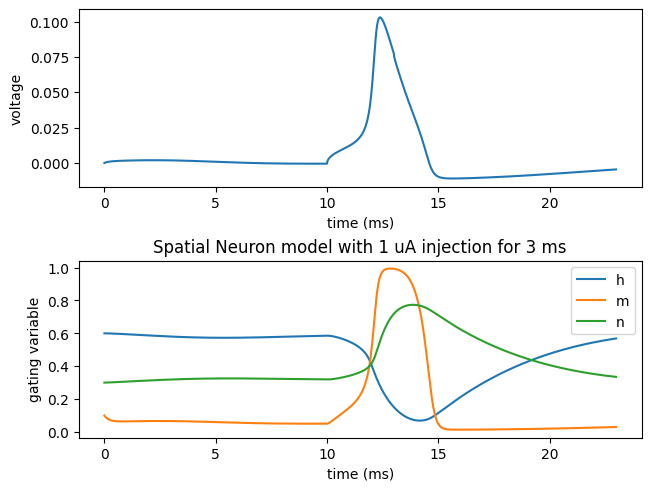

In [29]:
start_scope()
#eqn has a negative sign missed in original slides
E_leak = 10.613*mV
E_na = 115*mV
E_k = -12*mV
g_leak = 0.3*msiemens/cm**2
g_na = 120*msiemens/cm**2
g_k = 36*msiemens/cm**2
C_m = 1*uF/cm**2
R_l = 35.4*ohm*cm
#(-1*(g_na*(v-E_na)) + (g_k*(v-E_k))) + I  : amp/meter**2
#Im = (g_leak*(E_leak-v) - g_na*(m**3)*h*(v-E_na) - g_k*(n**4)*(v-E_k) + I)  : volt


# Fill in these equations
eqn = '''
Im = g_leak*(E_leak-v) + g_na*(m**3)*h*(E_na-v) + g_k*(n**4)*(E_k-v)  : amp/meter**2
dm/dt = alpha_m*(1-m) - beta_m*m : 1
dn/dt = alpha_n*(1-n) - beta_n*n : 1
dh/dt = alpha_h*(1-h) - beta_h*h : 1

alpha_m = (0.1/mV) * 10*mV/exprel((-v+25*mV)/(10*mV))/ms : Hz  # exprel(x) := (exp(x) - 1)/x
beta_m = 4 * exp(-v/(18*mV))/ms : Hz
alpha_h = 0.07 * exp(-v/(20*mV))/ms : Hz
beta_h = 1/(exp((-v+30*mV) / (10*mV)) + 1)/ms : Hz
alpha_n = (0.01/mV) * 10*mV/exprel((-v+10*mV)/(10*mV))/ms : Hz
beta_n = 0.125*exp(-v/(80*mV))/ms : Hz
I : amp (point current)  # applied external current
'''

cable = Cylinder(length=10*cm, diameter=2*238*um, n=1000, type='axon')

neuron = SpatialNeuron(morphology=cable, model=eqn, method="exponential_euler", Cm=C_m, Ri=R_l)

neuron.v = 0*mV
neuron.h = 0.6
neuron.m = 0.1
neuron.n = 0.3
defaultclock.dt = 0.01*ms

probe_v = StateMonitor(neuron, 'v', record=True)
probe_h = StateMonitor(neuron, 'h', record=True)
probe_m = StateMonitor(neuron, 'm', record=True)
probe_n = StateMonitor(neuron, 'n', record=True)


run(10*ms)
neuron.I[0] = 1*uA # current injection at one end of the axon
run(3*ms)
neuron.I = 0*uA
run(10*ms)

# plots here
fig, ax = plt.subplots(nrows=2, layout='constrained')
ax[0].plot(probe_v.t/ms, probe_v.v[0])
ax[0].set(xlabel='time (ms)', ylabel='voltage')
plt.title('Spatial Neuron model with 1 uA injection for 3 ms')

ax[1].plot(probe_h.t/ms, probe_h.h[0], label='h')
ax[1].plot(probe_m.t/ms, probe_m.m[0], label='m')
ax[1].plot(probe_n.t/ms, probe_n.n[0], label='n')
ax[1].set(xlabel='time (ms)', ylabel='gating variable')
plt.legend()
plt.title('Spatial Neuron model with 1 uA injection for 3 ms')
plt.show()

## 3.2 [0.5 point] Show that the action potential propagates down the cable with minimal attenuation.
- (a) plot voltage vs time at three points on the ```cable```: the left edge, center, and right edge.
- (b) increase the longitudinal resistance and show that the signal propagates slower.

WARNING    'I' is an internal variable of group 'spatialneuron_1', but also exists in the run namespace with the value array([ 1. ,  1.5,  2. , ..., 19. , 19.5, 20. ]) * mamp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'I' is an internal variable of group 'spatialneuron_2', but also exists in the run namespace with the value array([ 1. ,  1.5,  2. , ..., 19. , 19.5, 20. ]) * mamp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


[[   0.           74.39889897  144.01403724 ... -541.90094382
  -536.72328834 -531.55788486]] uV
[[ 0.          0.0743989   0.14401404 ... -3.14075935 -3.13135114
  -3.12195399]] mV
[[ 0.          0.0743989   0.14401404 ... -7.00707196 -6.99527575
  -6.98347579]] mV


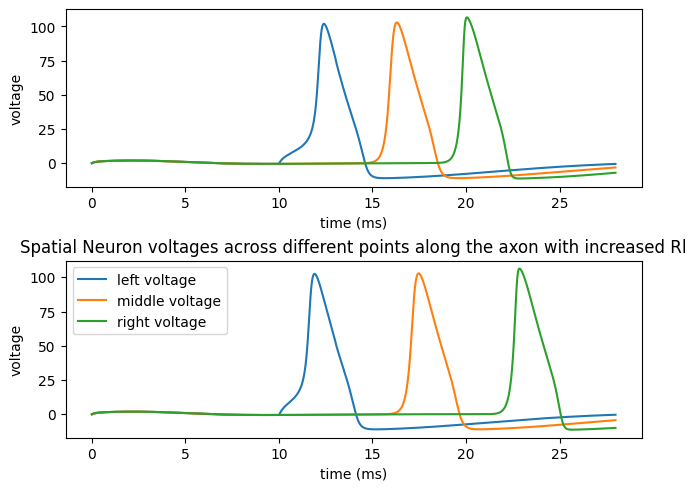

In [30]:
# your solution here
#a)
from brian2 import SpatialNeuron

start_scope()
E_leak = 10.613*mV
E_na = 115*mV
E_k = -12*mV
g_leak = 0.3*msiemens/cm**2
g_na = 120*msiemens/cm**2
g_k = 36*msiemens/cm**2
C_m = 1*uF/cm**2
R_l = 35.4*ohm*cm
R_l2 = 70*ohm*cm

eqn = '''
Im = g_leak*(E_leak-v) + g_na*(m**3)*h*(E_na-v) + g_k*(n**4)*(E_k-v)  : amp/meter**2
dm/dt = alpha_m*(1-m) - beta_m*m : 1
dn/dt = alpha_n*(1-n) - beta_n*n : 1
dh/dt = alpha_h*(1-h) - beta_h*h : 1

alpha_m = (0.1/mV) * 10*mV/exprel((-v+25*mV)/(10*mV))/ms : Hz  # exprel(x) := (exp(x) - 1)/x
beta_m = 4 * exp(-v/(18*mV))/ms : Hz
alpha_h = 0.07 * exp(-v/(20*mV))/ms : Hz
beta_h = 1/(exp((-v+30*mV) / (10*mV)) + 1)/ms : Hz
alpha_n = (0.01/mV) * 10*mV/exprel((-v+10*mV)/(10*mV))/ms : Hz
beta_n = 0.125*exp(-v/(80*mV))/ms : Hz
I : amp (point current)  # applied external current
'''

cable = Cylinder(length=10*cm, diameter=2*238*um, n=1000, type='axon')
neuron1 = SpatialNeuron(morphology=cable, model=eqn, method="exponential_euler", Cm=C_m, Ri=R_l)
neuron2 = SpatialNeuron(morphology=cable, model=eqn, method="exponential_euler", Cm=C_m, Ri=R_l2)

neuron1.v = 0*mV
neuron1.h = 0.6
neuron1.m = 0.1
neuron1.n = 0.3

neuron2.v = 0*mV
neuron2.h = 0.6
neuron2.m = 0.1
neuron2.n = 0.3

defaultclock.dt = 0.01*ms

probe_v1 = StateMonitor(neuron1, 'v', record=True)

left = neuron1.spatialneuron_segment(neuron1, 1)
middle = neuron1.spatialneuron_segment(neuron1, 5)
right = neuron1.spatialneuron_segment(neuron1, 9)

#probe_l=StateMonitor(, 'v', record=True)
#probe_m=StateMonitor(neuron1[5].v, 'v', record=True)
#probe_r=StateMonitor(neuron1[9].v, 'v', record=True)

pl=StateMonitor(neuron1[10], 'v', record=True)
pm=StateMonitor(neuron1[500], 'v', record=True)
pr=StateMonitor(neuron1[985 ], 'v', record=True)


pl2=StateMonitor(neuron2[10], 'v', record=True)
pm2=StateMonitor(neuron2[500], 'v', record=True)
pr2=StateMonitor(neuron2[985 ], 'v', record=True)

run(10*ms)
neuron1.I[0] = 1*uA # current injection at one end of the axon
neuron2.I[0] = 1*uA # current injection at one end of the axon

run(3*ms)
neuron1.I = 0*uA
neuron2.I = 0*uA

run(15*ms)

#verifiers
print(pl.v)
print(pm.v)
print(pr.v)

#plotting
fig, ax = plt.subplots(nrows=2, layout='constrained')

ax[0].plot(pl.t/ms, pl.v[0]/mV, label='left voltage')
ax[0].plot(pm.t/ms, pm.v[0]/mV, label='middle voltage')
ax[0].plot(pr.t/ms, pr.v[0]/mV, label='right voltage')
ax[0].set(xlabel='time (ms)', ylabel='voltage')


ax[1].plot(pl2.t/ms, pl2.v[0]/mV, label='left voltage')
ax[1].plot(pm2.t/ms, pm2.v[0]/mV, label='middle voltage')
ax[1].plot(pr2.t/ms, pr2.v[0]/mV, label='right voltage')
ax[1].set(xlabel='time (ms)', ylabel='voltage')

plt.title('Spatial Neuron voltages across different points along the axon with increased Rl')

plt.legend()
plt.show()




In [32]:
#b) increasing longitudinal resistance to depict signal slowing
R_l2 = 70*ohm*cm

neuron2 = SpatialNeuron(morphology=cable, model=eqn, method="exponential_euler", Cm=C_m, Ri=R_l2)
probe_v2 = StateMonitor(neuron2, 'v', record=True)

pl2=StateMonitor(neuron2.spatialneuron_segment(neuron2, 1), 'v', record=True)
pm2=StateMonitor(neuron2.spatialneuron_segment(neuron2, 5), 'v', record=True)
pr2=StateMonitor(neuron2.spatialneuron_segment(neuron2, 10), 'v', record=True)

run(10*ms)
neuron1.I[0] = 1*uA # current injection at one end of the axon
run(3*ms)
neuron1.I = 0*uA
run(10*ms)

fig, ax = plt.subplots(nrows=2, layout='constrained')
ax[0].plot(probe_v2.t/ms, probe_v.v[0])
ax[0].set(xlabel='time (ms)', ylabel='voltage')
plt.title('Spatial Neuron model with 1 uA injection for 3 ms')

ax[1].plot(pl2.t/ms, pl2.v[0]/mV, label='left voltage')
ax[1].plot(pm2.t/ms, pm2.v[0]/mV, label='middle voltage')
ax[1].plot(pr2.t/ms, pr2.v[0]/mV, label='right voltage')

plt.legend()
plt.show()

MagicError: The magic network contains a mix of objects that has been run before and new objects, Brian does not know whether you want to start a new simulation or continue an old one. Consider explicitly creating a Network object. Also note that you can find out which objects will be included in a magic network with the collect() function.

## 3.3 [0.5 point] Create a stimulus that produces a rebound spike, and plot the resulting voltage trace

WARNING    The object 'spatialneuron_3' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/tmp/ipython-input-3598556370.py', line 4, in <cell line: 0>
    neuron2 = SpatialNeuron(morphology=cable, model=eqn, method="exponential_euler", Cm=C_m, Ri=R_l2) [brian2.core.base.unused_brian_object]
WARNING    'I' is an internal variable of group 'spatialneuron_4', but also exists in the run namespace with the value array([ 1. ,  1.5,  2. , ..., 19. , 19.5, 20. ]) * mamp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


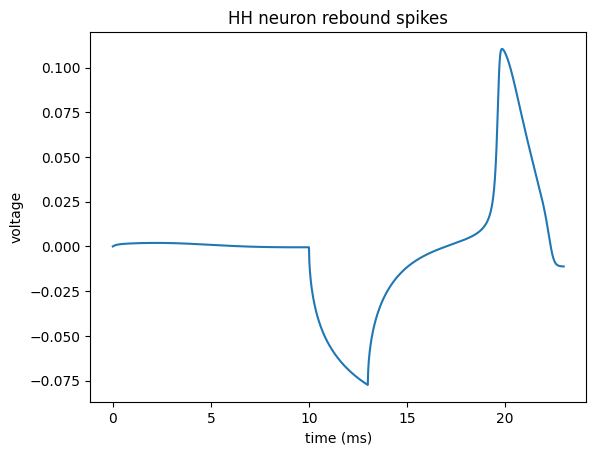

In [33]:
# your solution here
#a rebound spike would impact be the closure of the potassium channels
start_scope()
E_leak = 10.613*mV
E_na = 115*mV
E_k = -12*mV
g_leak = 0.3*msiemens/cm**2
g_na = 120*msiemens/cm**2
g_k = 36*msiemens/cm**2
C_m = 1*uF/cm**2
R_l = 35.4*ohm*cm
R_l2 = 70*ohm*cm

eqn = '''
Im = g_leak*(E_leak-v) + g_na*(m**3)*h*(E_na-v) + g_k*(n**4)*(E_k-v)  : amp/meter**2
dm/dt = alpha_m*(1-m) - beta_m*m : 1
dn/dt = alpha_n*(1-n) - beta_n*n : 1
dh/dt = alpha_h*(1-h) - beta_h*h : 1

alpha_m = (0.1/mV) * 10*mV/exprel((-v+25*mV)/(10*mV))/ms : Hz  # exprel(x) := (exp(x) - 1)/x
beta_m = 4 * exp(-v/(18*mV))/ms : Hz
alpha_h = 0.07 * exp(-v/(20*mV))/ms : Hz
beta_h = 1/(exp((-v+30*mV) / (10*mV)) + 1)/ms : Hz
alpha_n = (0.01/mV) * 10*mV/exprel((-v+10*mV)/(10*mV))/ms : Hz
beta_n = 0.125*exp(-v/(80*mV))/ms : Hz
I : amp (point current)  # applied external current
'''

cable = Cylinder(length=10*cm, diameter=2*238*um, n=1000, type='axon')
neuron3 = SpatialNeuron(morphology=cable, model=eqn, method="exponential_euler", Cm=C_m, Ri=R_l)

neuron3.v = 0*mV
neuron3.h = 0.6
neuron3.m = 0.1
neuron3.n = 0.3
defaultclock.dt = 0.01*ms


probe_v3 = StateMonitor(neuron3, 'v', record=True)

run(10*ms)
neuron3.I[0] = -5*uA # current injection at one end of the axon
run(3*ms)
neuron3.I = 0*uA
run(10*ms)

fig, ax = plt.subplots()
ax.plot(probe_v3.t/ms, probe_v3.v[0])
ax.set(xlabel='time (ms)', ylabel='voltage')
plt.title('HH neuron rebound spikes')
plt.show()


## 3.4 [2 points] Create a new cell morphology that includes a soma and a dendritic tree with one branch. Show that voltage attenuation increases with the distance from the soma.
- Use ```Cylinder()``` for dendritic sections, with geometric parameters in these ranges:
 - ```length=10-100um```
 - ```diameter=0.1-1um```
 - ```n=5-100```
- Choose several points along the tree as injection sites.
- For each site, apply an identical external current ```I=100*pA``` and measure the resulting voltage change at the soma ($\Delta v = v_{rest} - v_{max}$).
- Plot $\Delta v$ vs distance. How does attenuation vary within a section and between sections (especially at branch points)?

[0.] m
[0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5] um
[10.5 11.5 12.5 13.5 14.5 15.5 16.5 17.5 18.5 19.5 20.5 21.5 22.5 23.5
 24.5 25.5 26.5 27.5 28.5 29.5] um
[15. 25. 35. 45. 55.] um


INFO       No numerical integration method specified for group 'spatialneuron_3', using method 'exact' (took 5.91s). [brian2.stateupdaters.base.method_choice]
WARNING    'I' is an internal variable of group 'spatialneuron_3', but also exists in the run namespace with the value array([ 1. ,  1.5,  2. , ..., 19. , 19.5, 20. ]) * mamp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


-210.7808342 uV
<spatialneuron_3_subgroup_2.distance: array([15.]) * umetre>
[ 0.5 10.5 14.5 15.  29.5]
[-265.70511851 -225.74996478 -222.85613401 -210.7808342  -216.81934664]


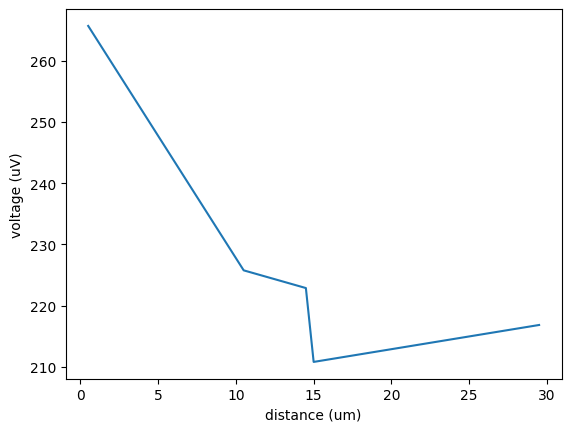

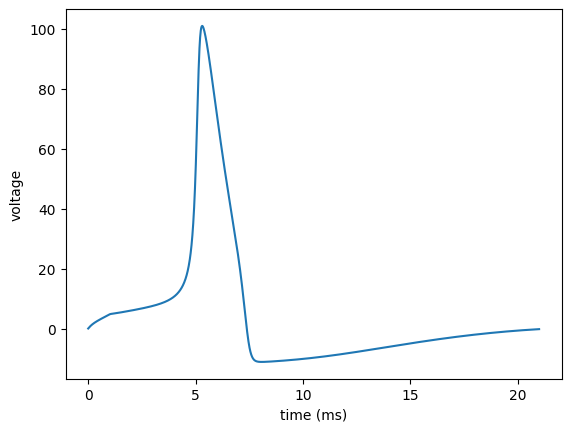

In [34]:
# your solution here

start_scope()
E_leak = 10.613*mV
E_na = 115*mV
E_k = -12*mV
g_leak = 0.3*msiemens/cm**2
g_na = 120*msiemens/cm**2
g_k = 36*msiemens/cm**2
C_m = 1*uF/cm**2
R_l = 35.4*ohm*cm

eqn = '''
Im = g_leak*(E_leak-v) + g_na*(m**3)*h*(E_na-v) + g_k*(n**4)*(E_k-v)  : amp/meter**2
dm/dt = alpha_m*(1-m) - beta_m*m : 1
dn/dt = alpha_n*(1-n) - beta_n*n : 1
dh/dt = alpha_h*(1-h) - beta_h*h : 1

alpha_m = (0.1/mV) * 10*mV/exprel((-v+25*mV)/(10*mV))/ms : Hz  # exprel(x) := (exp(x) - 1)/x
beta_m = 4 * exp(-v/(18*mV))/ms : Hz
alpha_h = 0.07 * exp(-v/(20*mV))/ms : Hz
beta_h = 1/(exp((-v+30*mV) / (10*mV)) + 1)/ms : Hz
alpha_n = (0.01/mV) * 10*mV/exprel((-v+10*mV)/(10*mV))/ms : Hz
beta_n = 0.125*exp(-v/(80*mV))/ms : Hz
I : amp (point current)  # applied external current
'''

soma = Soma(diameter=30*um)
soma.d1 = Cylinder(diameter=0.5*um, length=10*um, n=10)
soma.d1.d2 = Cylinder(diameter=1*um, length = 20*um, n = 20)
soma.d1.d3 = Cylinder(diameter=0.7*um, length=50*um, n = 5)

neuron4=SpatialNeuron(morphology=soma, model=eqn, Cm=C_m,Ri=R_l)
neuron4.v = 0*mV
neuron4.h = 0.6
neuron4.m = 0.1
neuron4.n = 0.3
defaultclock.dt = 0.01*ms

print(soma.distance)
print(soma.d1.distance)
print(soma.d1.d2.distance)
print(soma.d1.d3.distance)



soma.d1[0]
#print(neuron4[11].distance)
#print(neuron4.spatialneuron_segment(neuron4, 35).distance)

p=StateMonitor(neuron4.main, 'v', record=True)
probe1 = StateMonitor(neuron4[20],'v', record=True)

neuron4[31].I=100*pA
run(1*ms)

neuron4[31].I=0*pA
run(20*ms)
#print(p.v[0])
print(np.max(p.v[0,2000:]))
print(neuron4[31].distance)

distance = np.array([[0.5, 10.5, 14.5, 15, 29.5], [-265.70511851, -225.74996478, -222.85613401, -210.7808342, -216.81934664 ]])
print(distance[0])
print(distance[1])

fig, ax = plt.subplots()
ax.plot(distance[0], -1*distance[1])
ax.set(xlabel='distance (um)', ylabel='voltage (uV)')
plt.show()

fig, ax = plt.subplots()
ax.plot(p.t/ms, p.v[0]/ms)
ax.set(xlabel='time (ms)', ylabel='voltage')
plt.show()
#We just need delta_v = v_rest - v_max, so we can compute np.max() to find v_max instead of using find_peaks
#need to branch and then add, add both branches to end of dendrite

[0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5] um


INFO       No numerical integration method specified for group 'spatialneuron_5', using method 'exact' (took 0.00s). [brian2.stateupdaters.base.method_choice]
WARNING    'I' is an internal variable of group 'spatialneuron_5', but also exists in the run namespace with the value array([ 1. ,  1.5,  2. , ..., 19. , 19.5, 20. ]) * mamp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


<Subgroup 'spatialneuron_5_subgroup_1' of 'spatialneuron_5' from 12 to 13>
[array([0.5]) * umetre, array([1.5]) * umetre, array([2.5]) * umetre, array([3.5]) * umetre, array([4.5]) * umetre, array([5.5]) * umetre, array([6.5]) * umetre, array([7.5]) * umetre, array([8.5]) * umetre, array([9.5]) * umetre]
[102.63819665 * mvolt, 102.63909751 * mvolt, 102.64219258 * mvolt, 102.64669773 * mvolt, 102.65105349 * mvolt, 102.65293382 * mvolt, 102.65825974 * mvolt, 102.66678297 * mvolt, 102.67139623 * mvolt, 102.68127851 * mvolt]
[array([10.5]) * umetre, array([11.5]) * umetre, array([12.5]) * umetre, array([13.5]) * umetre, array([14.5]) * umetre, array([15.5]) * umetre, array([16.5]) * umetre, array([17.5]) * umetre, array([18.5]) * umetre, array([19.5]) * umetre, array([20.5]) * umetre, array([21.5]) * umetre, array([22.5]) * umetre, array([23.5]) * umetre, array([24.5]) * umetre, array([25.5]) * umetre, array([26.5]) * umetre, array([27.5]) * umetre, array([28.5]) * umetre, array([29.5]) * 

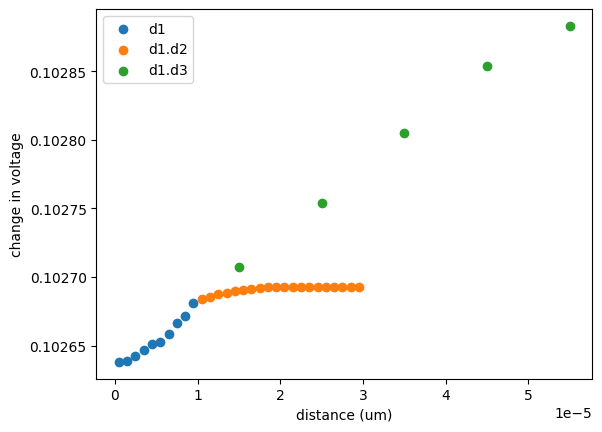

In [35]:
start_scope()
E_leak = 10.613*mV
E_na = 115*mV
E_k = -12*mV
g_leak = 0.3*msiemens/cm**2
g_na = 120*msiemens/cm**2
g_k = 36*msiemens/cm**2
C_m = 1*uF/cm**2
R_l = 35.4*ohm*cm

eqn = '''
Im = g_leak*(E_leak-v) + g_na*(m**3)*h*(E_na-v) + g_k*(n**4)*(E_k-v)  : amp/meter**2
dm/dt = alpha_m*(1-m) - beta_m*m : 1
dn/dt = alpha_n*(1-n) - beta_n*n : 1
dh/dt = alpha_h*(1-h) - beta_h*h : 1

alpha_m = (0.1/mV) * 10*mV/exprel((-v+25*mV)/(10*mV))/ms : Hz  # exprel(x) := (exp(x) - 1)/x
beta_m = 4 * exp(-v/(18*mV))/ms : Hz
alpha_h = 0.07 * exp(-v/(20*mV))/ms : Hz
beta_h = 1/(exp((-v+30*mV) / (10*mV)) + 1)/ms : Hz
alpha_n = (0.01/mV) * 10*mV/exprel((-v+10*mV)/(10*mV))/ms : Hz
beta_n = 0.125*exp(-v/(80*mV))/ms : Hz
I : amp (point current)  # applied external current
'''


#neuron morphology
soma = Soma(diameter=30*um)
soma.d1 = Cylinder(diameter=0.5*um, length=10*um, n=10)
soma.d1.d2 = Cylinder(diameter=1*um, length = 20*um, n = 20)
soma.d1.d3 = Cylinder(diameter=0.7*um, length=50*um, n = 5)


#defining the spatialneuron
print(soma.d1.distance)

distance_d1= [0,1,2,3,4,5,6,7,8,9]
voltage_d1=[0,1,2,3,4,5,6,7,8,9]

distance_d1d2=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
voltage_d1d2=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]

distance_d1d3=[0,1,2,3,4]
voltage_d1d3=[0,1,2,3,4]


for i in range(len(soma.d1.distance)):
   neuron4=SpatialNeuron(morphology=soma, model=eqn, Cm=C_m,Ri=R_l)
   neuron4.v = 0*mV
   neuron4.h = 0.6
   neuron4.m = 0.1
   neuron4.n = 0.3
   neuron4.I = 0*uA

   defaultclock.dt = 0.01*ms
   p = StateMonitor(neuron4.main, 'v', record=True)


   run(20*ms)

   neuron4.d1[i].I=100*pA
   run(1*ms)

   neuron4[i].I=0*pA
   run(20*ms)

   distance_d1[i] = soma.d1[i].distance
   voltage_d1[i] = np.max(p.v[0, 2000:])


for i in range(len(soma.d1.d2.distance)):
   start_scope()

   neuron4=SpatialNeuron(morphology=soma, model=eqn, Cm=C_m,Ri=R_l)
   neuron4.v = 0*mV
   neuron4.h = 0.6
   neuron4.m = 0.1
   neuron4.n = 0.3
   neuron4.I = 0*uA

   defaultclock.dt = 0.01*ms

   p = StateMonitor(neuron4.main, 'v', record=True)

   run(20*ms)

   neuron4.d1.d2[i].I=100*pA
   run(1*ms)

   neuron4[i].I=0*pA
   run(20*ms)

   distance_d1d2[i] = soma.d1.d2[i].distance
   voltage_d1d2[i] = np.max(p.v[0, 2000:])


for i in range(len(soma.d1.d3.distance)):
   start_scope()
   neuron4=SpatialNeuron(morphology=soma, model=eqn, Cm=C_m,Ri=R_l)
   neuron4.v = 0*mV
   neuron4.h = 0.6
   neuron4.m = 0.1
   neuron4.n = 0.3
   neuron4.I = 0*uA
   defaultclock.dt = 0.01*ms

   p = StateMonitor(neuron4.main, 'v', record=True)

   run(20*ms)

   neuron4.d1.d3[i].I=100*pA
   run(1*ms)

   neuron4[i].I=0*pA
   run(20*ms)

   distance_d1d3[i] = soma.d1.d3[i].distance
   voltage_d1d3[i] =  np.max(p.v[0, 2000:])


print(neuron4.d1.d2[1])
print(soma.d1.d2[1])

print(distance_d1)
print(voltage_d1)
print(distance_d1d2)
print(voltage_d1d2)
print(distance_d1d3)
print(voltage_d1d3)

fig, ax = plt.subplots()
ax.scatter(distance_d1, voltage_d1, label='d1')
ax.scatter(distance_d1d2, voltage_d1d2, label = 'd1.d2')
ax.scatter(distance_d1d3, voltage_d1d3, label='d1.d3')
plt.legend()
ax.set(xlabel='distance (um)', ylabel='change in voltage')
plt.show()



#for i in range(len(I)):     #a)
 #   spike_counts_a.append(LIF_response(I[i], R1, C1, tau_ref1))













0
[array([15.]) * umetre, array([25.]) * umetre, array([35.]) * umetre, array([45.]) * umetre, array([55.]) * umetre]
[102.63819665 * mvolt, 102.63909751 * mvolt, 102.64219258 * mvolt, 102.64669773 * mvolt, 102.65105349 * mvolt, 102.65293382 * mvolt, 102.65825974 * mvolt, 102.66678297 * mvolt, 102.67139623 * mvolt, 102.68127851 * mvolt]
[55.] um
102.63819665 mV
<Subgroup 'spatialneuron_5_subgroup_1' of 'spatialneuron_5' from 12 to 13>
[array([0.5]) * umetre, array([1.5]) * umetre, array([2.5]) * umetre, array([3.5]) * umetre, array([4.5]) * umetre, array([5.5]) * umetre, array([6.5]) * umetre, array([7.5]) * umetre, array([8.5]) * umetre, array([9.5]) * umetre]
[-0.1026382  -0.1026391  -0.10264219 -0.1026467  -0.10265105 -0.10265293
 -0.10265826 -0.10266678 -0.1026714  -0.10268128]
[array([10.5]) * umetre, array([11.5]) * umetre, array([12.5]) * umetre, array([13.5]) * umetre, array([14.5]) * umetre, array([15.5]) * umetre, array([16.5]) * umetre, array([17.5]) * umetre, array([18.5]) 

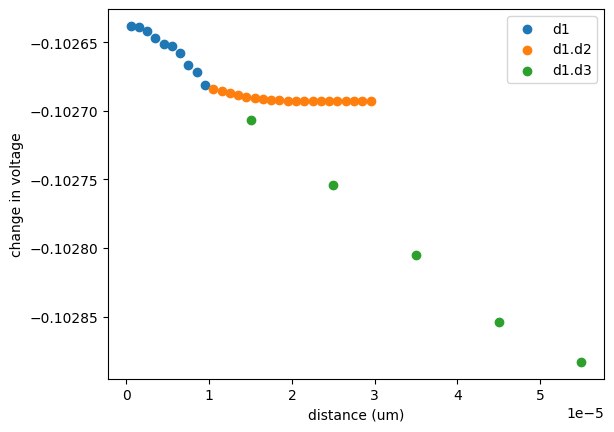

In [36]:
print(distance_d1.index(array([0.5]) * umetre))
print(distance_d1d3)
print(voltage_d1)
print(soma.d1.d3[i].distance)
neuron4.d1[0].distance
print(voltage_d1[0])

print(neuron4.d1.d2[1])
print(soma.d1.d2[1])

print(distance_d1)
print(-1*np.array(voltage_d1))
print(distance_d1d2)
print(voltage_d1d2)
print(distance_d1d3)
print(voltage_d1d3)
print(neuron4.d1.I[2])
d1 = np.arange(0.5,10, 0.5)
d2 = np.arange(10.5, 30, 0.5)
d3 = np.arange(15, 65, 10)

fig, ax = plt.subplots()
ax.scatter(distance_d1, -1*np.array(voltage_d1), label='d1')
ax.scatter(distance_d1d2, -1*np.array(voltage_d1d2), label = 'd1.d2')
ax.scatter(distance_d1d3, -1*np.array(voltage_d1d3), label='d1.d3')
plt.legend()
ax.set(xlabel='distance (um)', ylabel='change in voltage')
plt.show()

In [40]:
x=np.arange(10)
print(x)
x.shape=(2,5)
print(x[1])

[0 1 2 3 4 5 6 7 8 9]
[5 6 7 8 9]


Your description of attenuation here
#question on detecting spike in cont signal = look for peak (suboptimal maxima)
function to find peaks found scipy.signal.find_peaks
